# Clustering using k-means and GMM

Clustering is the task of grouping a set of objects without known their labels. It is one of the most fundamental methods for unsupervised learning. We will start with the simple k-means method and then progress to the Gaussian Mixture Method (GMM).

This notebook is based on a blog post by [Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html) on clustering with [scikit-learn](https://scikit-learn.org/stable/index.html), an excerpt from his book [*Python Data Science Handbook*](https://www.oreilly.com/library/view/python-data-science/9781491912126/).

In [1]:
# sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import make_moons
from sklearn import metrics
import sklearn.datasets

# helpers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
plt.style.use('ggplot')

---

# K-means

K-means is probably the most popular clustering method. It clusters the data by minimising the within-cluster sum of squares (WCSS), i.e., given data $\mathbf{x}$ and the number of clusters $k$, to find a set of clusters $\mathbf{S}=\{S_1, S_2, \cdots, S_k\}$ by

$$\operatorname*{arg\,min}_\mathbf{S} \sum_{i=1}^k \sum_{\mathbf{x}\in S_i}\lVert\mathbf{x}-\mathbf{\mu}_i\rVert^2,$$

where $\mathbf{\mu}_i$ is the mean of points in cluster $S_i$.


## Data generation

First, similar to [classification_decision_tree.ipynb](classification_decision_tree.ipynb), we use a dataset generated by the `make_blobs` method from `sklearn`. It has 400 samples with 2 features, 4 centres and a standard deviation of 0.6. Note that we flip the axes (2nd feature as $x$-axis) in the plot for better visualisation. 

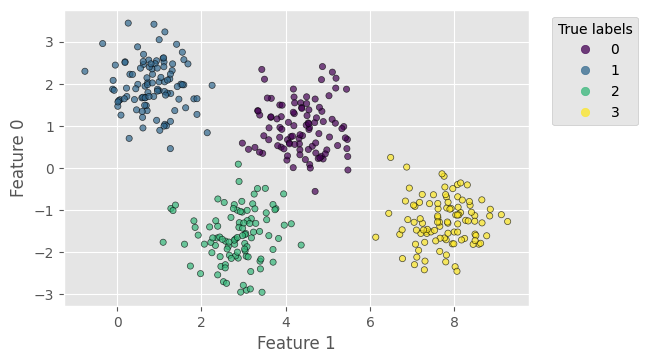

In [2]:
# generate Gaussian blobs
X, y_true = make_blobs(n_samples=400, n_features=2, centers=4,
                       cluster_std=0.6, random_state=0)

# plot data points with true labels
plt.figure(dpi=100)
scat = plt.scatter(X[:, 1], X[:, 0], c=y_true, s=20, alpha=0.7, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 0')
plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                                title='True labels', bbox_to_anchor=(1.25, 1.)))
plt.gca().set_aspect(1)
plt.show()

## Clustering using k-means

With `sklearn`, clustering using k-means is only a few lines:

In [3]:
# create k-means and fit
kmeans = KMeans(4, random_state=0).fit(X)

# make predictions
y_kmeans = kmeans.predict(X)

Now we can plot the resultant clusters. For better visualisation, we add the "range circles" to the plot, centred at the cluster means (`kmeans.cluster_centers_`) and having radii from the means to the farthest points.

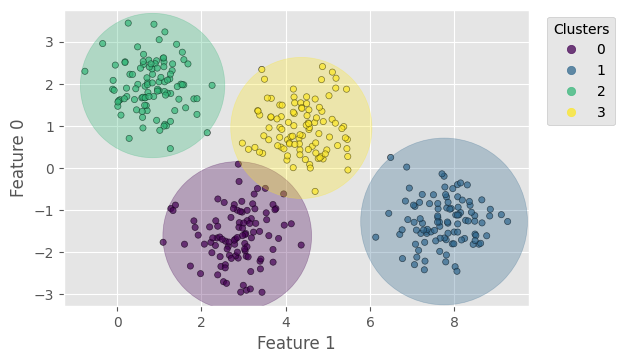

In [4]:
# plot data points with predicted labels
plt.figure(dpi=100)
scat = plt.scatter(X[:, 1], X[:, 0], c=y_kmeans, s=20, 
                   alpha=0.7, edgecolors='k', cmap='viridis')
# add the range circles
for icenter, center in enumerate(kmeans.cluster_centers_):
    radius = np.max(np.linalg.norm(X[y_kmeans == icenter] - center, axis=1))
    circle = plt.Circle((center[1], center[0]), radius, alpha=.3, 
                        color=cm.get_cmap('viridis', kmeans.n_clusters)(icenter))
    plt.gca().add_artist(circle)
plt.xlabel('Feature 1')
plt.ylabel('Feature 0')
plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                                title='Clusters', bbox_to_anchor=(1.2, 1.)))
plt.gca().set_aspect(1)
plt.show()

With `cluster_std=0.6`, k-means yields a prediction exactly the same as the ground truth; the only difference is the order of labels (which is reasonable because k-means takes in no information about the true labels). We can compute the following score for the clustering, all independent of the label orders:

* Homogeneity score: a clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class;
* Completeness score: a clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster;
* V-measure score: the harmonic mean between homogeneity and completeness.

For, `cluster_std=0.6`, the scores should all be 1. Try a larger `cluster_std`.

In [5]:
# print scores
print('Homogeneity score = %.3f' % metrics.homogeneity_score(y_true, y_kmeans))
print('Completeness score = %.3f' % metrics.completeness_score(y_true, y_kmeans))
print('V-measure score = %.3f' % metrics.v_measure_score(y_true, y_kmeans))

Homogeneity score = 1.000
Completeness score = 1.000
V-measure score = 1.000


---

# Gaussian Mixture Method

In k-means, the objective function (the WCSS) is isotropic; for example, it defines a circle in 2D (2 features) and a sphere in 3D (3 features). If the data distribution is anisotropic along the dimensions (e.g., all the data points lie on the $x$-axis), k-means will suffer from over-expanded cluster ranges along the minor dimensions.  

The Gaussian Mixture Method (GMM) can overcome this difficulty.  In GMM, each cluster is defined by a normal distribution rather than a single point (i.e., the centres in k-means), as shown in the following figure ([source](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95)). In a multivariate problem, each cluster is characterised by a series of Gaussian bells along each of the dimensions, forming an ellipsoidal range that can handle anisotropic data. 

<img src="https://github.com/stfc-sciml/sciml-workshop-v3/blob/master/course_3.0_with_solutions/markdown_pic/gmm.png?raw=1\" width=60% height=60% />

In GMM, clustering is conducted by maximising the likelihood of each Gaussian fitting the data points belonging to each cluster, so the solution is a maximum likelihood (ML) estimate. Further, variational inference can be introduced to GMM, giving rise to the Bayesian GMM, of which the solution is a maximum a posteriori probability (MAP) estimate.





## Data transformation

To create an anisotropic data distribution, we stretch the previous dataset by applying a random transformation matrix to the coordinates:

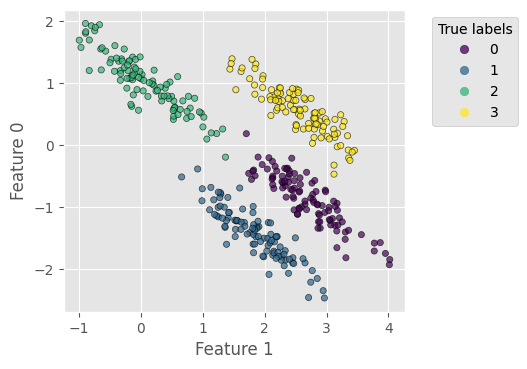

In [6]:
# stretch the data
# for reproducibility, we fix the random seed here
rng = np.random.RandomState(13)
X_stretch = np.dot(X, rng.randn(2, 2))

# plot data points with true labels
plt.figure(dpi=100)
scat = plt.scatter(X_stretch[:, 1], X_stretch[:, 0], c=y_true, s=20, 
                   alpha=0.7, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 0')
plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                                title='True labels', bbox_to_anchor=(1.35, 1.)))
plt.gca().set_aspect(1)
plt.show()

Let us try k-means with this stretched dataset -- the result clearly reflects the difficulty described above:

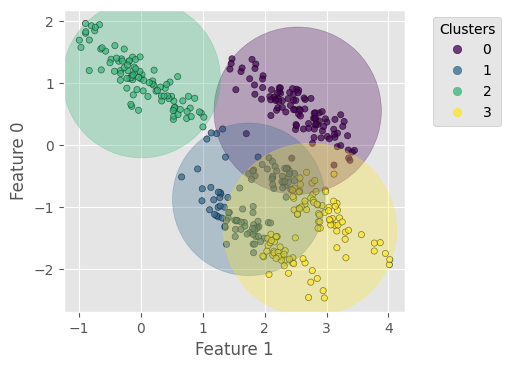

Homogeneity score = 0.700
Completeness score = 0.701
V-measure score = 0.701


In [7]:
# create k-means and fit
kmeans_stretch = KMeans(4, random_state=0).fit(X_stretch)

# make predictions
y_kmeans_stretch = kmeans_stretch.predict(X_stretch)

# plot data points with predicted labels
plt.figure(dpi=100)
scat = plt.scatter(X_stretch[:, 1], X_stretch[:, 0], c=y_kmeans_stretch, s=20, 
                   alpha=0.7, edgecolors='k', cmap='viridis')
# add the range circles
for icenter, center in enumerate(kmeans_stretch.cluster_centers_):
    radius = np.max(np.linalg.norm(X_stretch[y_kmeans_stretch == icenter] - center, axis=1))
    circle = plt.Circle((center[1], center[0]), radius, alpha=.3, 
                        color=cm.get_cmap('viridis', kmeans_stretch.n_clusters)(icenter))
    plt.gca().add_artist(circle)
plt.xlabel('Feature 1')
plt.ylabel('Feature 0')
plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                                title='Clusters', bbox_to_anchor=(1.3, 1.)))
plt.gca().set_aspect(1)
plt.show()

# print scores
print('Homogeneity score = %.3f' % metrics.homogeneity_score(y_true, y_kmeans_stretch))
print('Completeness score = %.3f' % metrics.completeness_score(y_true, y_kmeans_stretch))
print('V-measure score = %.3f' % metrics.v_measure_score(y_true, y_kmeans_stretch))

## Clustering using GMM

With `sklearn`, using GMM involves nothing more complicated than using k-means except for a few more hyperparameters (see [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)). The number of clusters is given by the argument `n_components`. To guarantee that we always reach the global optimal solution, here we specify `n_init=20`, the number of initial random states from which the best result will be chosen.

In [8]:
# create GMM and fit
gmm = GMM(n_components=4, n_init=20).fit(X_stretch)

# make predictions
y_gmm = gmm.predict(X_stretch)

Next, we plot the resultant clusters with the "range ellipses" and print the scores:

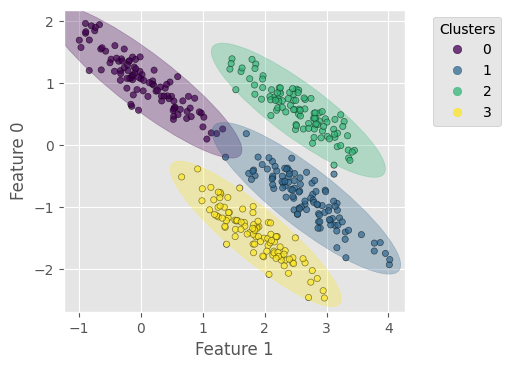

Homogeneity score = 0.980
Completeness score = 0.980
V-measure score = 0.980


In [9]:
# function to add ellipses of a GMM to a plot
def add_ellipses(gmm, ax, cmap):
    for n in range(gmm.n_components):
        # get covariances
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        # compute ellipse geometry
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.degrees(np.arctan2(u[0], u[1]))
        v = 4. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse((gmm.means_[n, 1], gmm.means_[n, 0]), v[1], v[0],
                                  90 + angle, color=cmap(n), alpha=.3)
        ax.add_artist(ell)
        
# plot data points with predicted labels
plt.figure(dpi=100)
scat = plt.scatter(X_stretch[:, 1], X_stretch[:, 0], c=y_gmm, 
                   s=20, alpha=0.7, edgecolors='k', cmap='viridis')
add_ellipses(gmm, plt.gca(), cm.get_cmap('viridis', gmm.n_components))
plt.xlabel('Feature 1')
plt.ylabel('Feature 0')
plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                                title='Clusters', bbox_to_anchor=(1.3, 1.)))
plt.gca().set_aspect(1)
plt.show()

# print scores
print('Homogeneity score = %.3f' % metrics.homogeneity_score(y_true, y_gmm))
print('Completeness score = %.3f' % metrics.completeness_score(y_true, y_gmm))
print('V-measure score = %.3f' % metrics.v_measure_score(y_true, y_gmm))

In addition, because GMM contains a probabilistic model under the hood, it is also possible to find the probabilistic cluster assignments, which is implemented by the `predict_proba` method in `sklearn`. It returns a matrix of size `[n_samples, n_components]`, which measures the probability that a point belongs to a cluster. 

In [10]:
# predict probability
probs = gmm.predict_proba(X)

# show the last 5 samples
print(probs[:5].round(3))

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Tune the number of clusters

It seems a little frustrating that we need to choose the number of clusters by hand. Is there any automatic way of selecting this? The answer is yes. Because the GMM yields a distribution of probabilities, it can be used to generate new samples within that distribution. We can then estimate the likelihood that the data we have observed would be generated by a particular GMM. Therefore, we can generate a set of GMMs with different numbers of clusters and find which one has the maximum likelihood of generating (reproducing) our observed data.

First, we make a set of GMMs with `n_components` ranging from 1 to 10:

In [11]:
# a set of numbers of clusters
n_components = np.arange(1, 11)

# create the GMM models
models = [GMM(n, n_init=20).fit(X_stretch) for n in n_components]

The GMM in `sklearn` has a couple of built-in methods to estimate how well the model matches the data, such as the Akaike information criterion (AIC) and the Bayesian information criterion (BIC):

In [12]:
# Akaike information criterion
aics = [m.aic(X_stretch) for m in models]

# Bayesian information criterion
bics = [m.bic(X_stretch) for m in models]

Plotting AIC and BIC against `n_components`, we find that 4 is the optimal number of clusters:

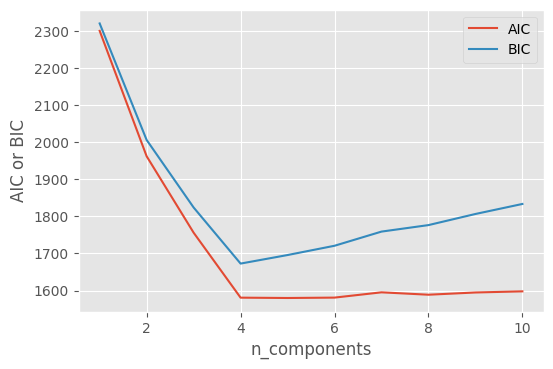

In [13]:
plt.figure(dpi=100)
plt.plot(n_components, aics, label='AIC')
plt.plot(n_components, bics, label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('AIC or BIC')
plt.show()

---

## Exercises:

1. The famous `two-moons` dataset can be generated by `sklearn`. Work out the best number of GMM clusters for replicating this data.

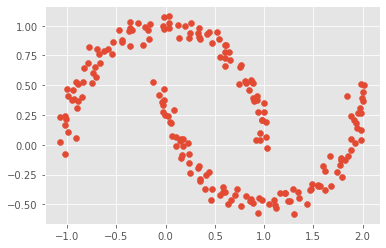

In [14]:
# load the two-moons dataset
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

2. Use k-means or GMM to cluster one or some of the standard "toy" datasets we have used to practice classification, such as `iris` (`n_features=4`) and `wine` (`n_features=13`). You may notice that the complexity of the problem rapidly grows with the number of features. In [autoencoder_basics.ipynb](../AE/autoencoder_basics.ipynb), we will train an autoencoder to reduce the input dimensionality for clustering. 

In [15]:
# load iris dataset
iris = sklearn.datasets.load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========